# 01 - Data Cleaning & Preprocessing
> Mục tiêu: Làm sạch dữ liệu, xử lý giá trị thiếu, mã hóa, loại bỏ nhiễu và giá trị ngoại lệ. Kết quả đầu ra: File `processed.csv` hoàn chỉnh, sẵn sàng để huấn luyện mô hình.

## 1.1: Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import joblib

## 1.2: Đọc dữ liệu

In [2]:
# Đọc file CSV từ thư mục data/
df = pd.read_csv("../data/raw/Student Depression Dataset.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')  # Loại bỏ khoảng trắng thừa trong tên cột
df.head()

,id,gender,age,city,profession,academic_pressure,work_pressure,cgpa,study_satisfaction,job_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts_?,work/study_hours,financial_stress,family_history_of_mental_illness,depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


### chuyển cột age sang dạng int 32

In [3]:
df['age'] = df['age'].astype('int32')

## 1.3: Kiểm tra thông tin dữ liệu

In [4]:
# Tổng quan về dữ liệu
df.info()

# Kiểm tra giá trị thiếu
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   gender                                 27901 non-null  object 
 2   age                                    27901 non-null  int32  
 3   city                                   27901 non-null  object 
 4   profession                             27901 non-null  object 
 5   academic_pressure                      27901 non-null  float64
 6   work_pressure                          27901 non-null  float64
 7   cgpa                                   27901 non-null  float64
 8   study_satisfaction                     27901 non-null  float64
 9   job_satisfaction                       27901 non-null  float64
 10  sleep_duration                         27901 non-null  object 
 11  di

id                                       0
gender                                   0
age                                      0
city                                     0
profession                               0
academic_pressure                        0
work_pressure                            0
cgpa                                     0
study_satisfaction                       0
job_satisfaction                         0
sleep_duration                           0
dietary_habits                           0
degree                                   0
have_you_ever_had_suicidal_thoughts_?    0
work/study_hours                         0
financial_stress                         3
family_history_of_mental_illness         0
depression                               0
dtype: int64

In [5]:
print(df['degree'].unique())
df['degree'].nunique()

['B.Pharm' 'BSc' 'BA' 'BCA' 'M.Tech' 'PhD' 'Class 12' 'B.Ed' 'LLB' 'BE'
 'M.Ed' 'MSc' 'BHM' 'M.Pharm' 'MCA' 'MA' 'B.Com' 'MD' 'MBA' 'MBBS' 'M.Com'
 'B.Arch' 'LLM' 'B.Tech' 'BBA' 'ME' 'MHM' 'Others']


28

## 1.4: Xử lý giá trị thiếu nhỏ hơn 5%

In [6]:
# Điền trung bình (hoặc mode) nếu cột thiếu ít
for col in df.columns:
    missing_ratio = df[col].isnull().sum() / len(df)
    if 0 < missing_ratio < 0.05:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].mean())

## 1.5:Loại bỏ các thuộc tính dư thừa

### 1.5.1: Loại bỏ cột không có giá trị học máy

In [7]:
cols_to_drop = ['id', 'work_pressure', 'job_satisfaction','profession']
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

### 1.5.2: Loại bỏ các thông tin thành phố sai lệch

In [8]:
invalid_city_names = [
    'Saanvi', 'Bhavna', 'Mira', 'Harsha', 'Vaanya', 'Gaurav', 'Harsh', 'Reyansh', 'Rashi', 'Mihir',
    'Nalini', 'Nandini', 'M.Tech', 'ME', 'M.Com', 'Nalyan', 'Khaziabad', 'Less Delhi', 'City', '3.0', 'Less than 5 Kalyan'
]

df = df[~df['city'].isin(invalid_city_names)]

## 1.6: Ánh xạ Việt hóa giá trị city và degree

### 1.6.1 Ánh xạ thành phố và gán giá trị theo cấp độ đô thị

In [9]:
# Cấp độ đô thị Ấn Độ
city_level_map = {
    # S - Siêu đô thị
    'Mumbai': 'S',
    'Delhi': 'S',

    # I - Đô thị trung tâm
    'Bangalore': 'I', 'Kolkata': 'I', 'Chennai': 'I', 'Hyderabad': 'I',

    # II - Công nghiệp / Kinh tế lớn
    'Pune': 'II', 'Ahmedabad': 'II', 'Surat': 'II', 'Kanpur': 'II',

    # III - Thủ phủ & Vùng
    'Lucknow': 'III', 'Jaipur': 'III', 'Nagpur': 'III', 'Indore': 'III',
    'Patna': 'III', 'Bhopal': 'III', 'Visakhapatnam': 'III',

    # IV - Vệ tinh & CN nhỏ
    'Thane': 'IV', 'Ghaziabad': 'IV', 'Faridabad': 'IV', 'Vadodara': 'IV',
    'Meerut': 'IV', 'Nashik': 'IV', 'Kalyan': 'IV', 'Vasai-Virar': 'IV',
    'Rajkot': 'IV', 'Ludhiana': 'IV',

    # V - Đặc thù
    'Srinagar': 'V', 'Varanasi': 'V', 'Agra': 'V'
}
vn_city_groups = {
    'Đặc Biệt': ['Hà Nội', 'TP. Hồ Chí Minh'],
    'I': ['Hải Phòng', 'Đà Nẵng', 'Cần Thơ'],
    'II': ['Bình Dương', 'Đồng Nai', 'Bà Rịa - Vũng Tàu', 'Bắc Ninh', 'Quảng Ninh', 'Vĩnh Phúc', 'Thái Nguyên', 'Hải Dương'],
    'III': ['Thanh Hóa', 'Nghệ An', 'Khánh Hòa', 'Thừa Thiên Huế', 'Long An', 'Tiền Giang', 'Bắc Giang', 'Quảng Nam', 'Bình Định', 'Đắk Lắk'],
    'IV': ['Thái Bình', 'Hưng Yên', 'Nam Định', 'Hà Nam', 'Ninh Bình',
           'Bình Thuận', 'Phú Yên', 'Quảng Ngãi', 'Hà Tĩnh', 'Quảng Bình', 'Quảng Trị', 'Ninh Thuận',
           'An Giang', 'Kiên Giang', 'Bến Tre', 'Vĩnh Long', 'Trà Vinh', 'Sóc Trăng', 'Bạc Liêu', 'Cà Mau', 'Hậu Giang'],
    'V': ['Hà Giang', 'Cao Bằng', 'Bắc Kạn', 'Lạng Sơn', 'Tuyên Quang', 'Yên Bái', 'Lào Cai', 'Lai Châu',
          'Điện Biên', 'Sơn La', 'Hòa Bình', 'Kon Tum', 'Gia Lai', 'Đắk Nông', 'Lâm Đồng', 'Bình Phước', 'Tây Ninh'],
    'Di sản': ['Huế', 'Quảng Nam', 'Lâm Đồng', 'Ninh Bình']
}


### 1.6.2: Viết hàm ánh xạ xác suất theo quy tắc của từng cấp độ

In [10]:
import random

def map_indian_city_to_vietnamese(city):
    level = city_level_map.get(city)
    if not level:
        return "Khác"

    if level == 'S':
        choices = vn_city_groups['Đặc Biệt'] * 7 + vn_city_groups['I'] * 2 + vn_city_groups['II']
    elif level == 'I':
        choices = vn_city_groups['Đặc Biệt'] * 4 + (vn_city_groups['I'] + vn_city_groups['II']) * 4 + vn_city_groups['III'] * 2
    elif level == 'II':
        choices = vn_city_groups['II'] * 5 + (vn_city_groups['I'] + vn_city_groups['Đặc Biệt']) * 3 + vn_city_groups['III'] * 2
    elif level == 'III':
        choices = vn_city_groups['III'] * 4 + vn_city_groups['IV'] * 3 + vn_city_groups['II'] * 2 + (vn_city_groups['I'] + vn_city_groups['Đặc Biệt'])
    elif level == 'IV':
        choices = vn_city_groups['IV'] * 5 + vn_city_groups['III'] * 3 + vn_city_groups['V'] + vn_city_groups['II']
    elif level == 'V':
        choices = vn_city_groups['Di sản'] * 6 + (vn_city_groups['IV'] + vn_city_groups['III']) * 3 + ['Khác']
    else:
        return "Khác"

    return random.choice(choices)


### 1.6.3: Ánh xạ sang bằng cấp Việt Nam

In [11]:
degree_mapping = {
    # Phổ thông
    'Class 12': 'Tốt nghiệp THPT',

    # Cử nhân
    'BA': 'Cử nhân Xã hội & Nhân văn',
    'BSc': 'Cử nhân Khoa học Tự nhiên',
    'B.Com': 'Cử nhân Thương mại / Kinh tế',
    'BBA': 'Cử nhân Quản trị Kinh doanh',
    'BCA': 'Cử nhân CNTT',
    'BHM': 'Cử nhân Quản lý Khách sạn',
    'B.Ed': 'Cử nhân Sư phạm',
    'LLB': 'Cử nhân Luật',
    'BE': 'Kỹ sư',
    'B.Tech': 'Kỹ sư Công nghệ',
    'B.Arch': 'Kiến trúc sư',
    'B.Pharm': 'Dược sĩ Đại học',
    'MBBS': 'Bác sĩ Đa khoa',

    # Thạc sĩ
    'MA': 'Thạc sĩ Xã hội & Nhân văn',
    'MSc': 'Thạc sĩ Khoa học Tự nhiên',
    'M.Com': 'Thạc sĩ Thương mại',
    'MBA': 'Thạc sĩ Quản trị Kinh doanh',
    'MCA': 'Thạc sĩ CNTT',
    'MHM': 'Thạc sĩ Quản lý Khách sạn',
    'M.Ed': 'Thạc sĩ Giáo dục',
    'LLM': 'Thạc sĩ Luật',
    'ME': 'Thạc sĩ Kỹ thuật',
    'M.Tech': 'Thạc sĩ Kỹ thuật Công nghệ',
    'M.Pharm': 'Thạc sĩ Dược học',
    'MD': 'Bác sĩ Chuyên khoa',

    # Tiến sĩ
    'PhD': 'Tiến sĩ',

    # Khác
    'Others': 'Khác'
}


### 1.6.4: Cập nhật dataframe

In [12]:
df['City_Viet'] = df['city'].apply(map_indian_city_to_vietnamese)
df['city'] = df['City_Viet']
df.drop(columns=['City_Viet'], inplace=True)
df['Degree_Viet'] = df['degree'].map(degree_mapping)
df['degree'] = df['Degree_Viet']
df.drop(columns=['Degree_Viet'], inplace=True)

In [13]:
df.head()

,gender,age,city,academic_pressure,cgpa,study_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts_?,work/study_hours,financial_stress,family_history_of_mental_illness,depression
0,Male,33,Thừa Thiên Huế,5.0,8.97,2.0,5-6 hours,Healthy,Dược sĩ Đại học,Yes,3.0,1.0,No,1
1,Female,24,Thanh Hóa,2.0,5.90,5.0,5-6 hours,Moderate,Cử nhân Khoa học Tự nhiên,No,3.0,2.0,Yes,0
2,Male,31,Bình Định,3.0,7.03,5.0,Less than 5 hours,Healthy,Cử nhân Xã hội & Nhân văn,No,9.0,1.0,Yes,0
3,Female,28,Ninh Bình,3.0,5.59,2.0,7-8 hours,Moderate,Cử nhân CNTT,Yes,4.0,5.0,Yes,1
4,Female,25,Đà Nẵng,4.0,8.13,3.0,5-6 hours,Moderate,Thạc sĩ Kỹ thuật Công nghệ,Yes,1.0,1.0,No,0


## 1.7: Xử lý ngoại lệ với IQR (Interquartile Range)

In [14]:
def remove_outliers_iqr(data, cols):
    for col in cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower) & (data[col] <= upper)]
    return data

# Áp dụng cho các cột số
numeric_cols = ['age','cgpa', 'academic_pressure', 'study_satisfaction',
                'work/study_hours', 'financial_stress']

df = remove_outliers_iqr(df, numeric_cols)

In [15]:
df.head()

,gender,age,city,academic_pressure,cgpa,study_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts_?,work/study_hours,financial_stress,family_history_of_mental_illness,depression
0,Male,33,Thừa Thiên Huế,5.0,8.97,2.0,5-6 hours,Healthy,Dược sĩ Đại học,Yes,3.0,1.0,No,1
1,Female,24,Thanh Hóa,2.0,5.90,5.0,5-6 hours,Moderate,Cử nhân Khoa học Tự nhiên,No,3.0,2.0,Yes,0
2,Male,31,Bình Định,3.0,7.03,5.0,Less than 5 hours,Healthy,Cử nhân Xã hội & Nhân văn,No,9.0,1.0,Yes,0
3,Female,28,Ninh Bình,3.0,5.59,2.0,7-8 hours,Moderate,Cử nhân CNTT,Yes,4.0,5.0,Yes,1
4,Female,25,Đà Nẵng,4.0,8.13,3.0,5-6 hours,Moderate,Thạc sĩ Kỹ thuật Công nghệ,Yes,1.0,1.0,No,0


## 1.8: Mã hóa dữ liệu phân loại

In [16]:
# Làm sạch trước khi map (cho tất cả cột nhị phân)
for col in ['gender', 'have_you_ever_had_suicidal_thoughts_?', 'family_history_of_mental_illness']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.lower()
# Mã hóa các cột nhị phân
binary_map = {
    'gender': {'male': 1, 'female': 0},
    'have_you_ever_had_suicidal_thoughts_?': {'yes': 1, 'no': 0},
    'family_history_of_mental_illness': {'yes': 1, 'no': 0}
}

for col, mapping in binary_map.items():
    df[col] = df[col].map(mapping)

# Label Encoding các cột còn lại
multi_cat_cols = ['city', 'degree', 'sleep_duration', 'dietary_habits']

label_encoders = {}
for col in multi_cat_cols:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
joblib.dump(label_encoders, '../models/label_encoders.pkl')

['../models/label_encoders.pkl']

In [17]:
df.head()

,gender,age,city,academic_pressure,cgpa,study_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts_?,work/study_hours,financial_stress,family_history_of_mental_illness,depression
0,1,33,50,5.0,8.97,2.0,0,0,10,1,3.0,1.0,0,1
1,0,24,47,2.0,5.90,5.0,0,1,3,0,3.0,2.0,1,0
2,1,31,5,3.0,7.03,5.0,2,0,9,0,9.0,1.0,1,0
3,0,28,36,3.0,5.59,2.0,1,1,2,1,4.0,5.0,1,1
4,0,25,59,4.0,8.13,3.0,0,1,20,1,1.0,1.0,0,0


## 1.9: Kiểm tra lần cuối & lưu dữ liệu đã xử lý

In [18]:
print("Dữ liệu sau xử lý:")
print(df.info())
# Lưu lại dữ liệu sạch để dùng cho bước tiếp theo
df.to_csv("../data/processed/processed.csv", index=False)
print("Đã lưu file: data/processed/processed.csv")


Dữ liệu sau xử lý:
<class 'pandas.core.frame.DataFrame'>
Index: 27855 entries, 0 to 27900
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 27855 non-null  int64  
 1   age                                    27855 non-null  int32  
 2   city                                   27855 non-null  int32  
 3   academic_pressure                      27855 non-null  float64
 4   cgpa                                   27855 non-null  float64
 5   study_satisfaction                     27855 non-null  float64
 6   sleep_duration                         27855 non-null  int32  
 7   dietary_habits                         27855 non-null  int32  
 8   degree                                 27855 non-null  int32  
 9   have_you_ever_had_suicidal_thoughts_?  27855 non-null  int64  
 10  work/study_hours                       27855 non-null  f

C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


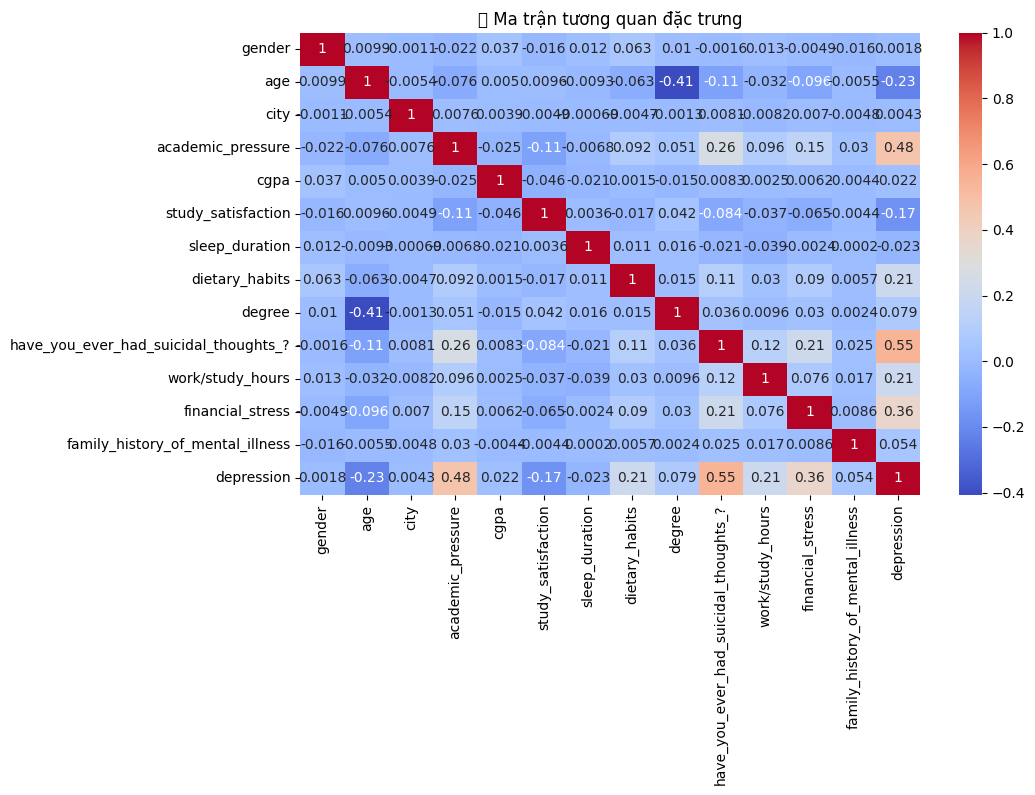

In [19]:
#Kiểm tra tương quan sơ bộ
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("🔍 Ma trận tương quan đặc trưng")
plt.show()